In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import gensim as gs
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
from sklearn.metrics import accuracy_score

In [2]:
read_file = pd.read_csv('dataset/train_dataset_1_1', delimiter=',', header=None)
train_dataset = read_file.iloc[:,:].values

In [3]:
read_file = pd.read_csv('dataset/validation_dataset_1_1', delimiter=',', header=None)
validation_dataset = read_file.iloc[:,:].values

In [4]:
read_file = pd.read_csv('dataset/testDataset', delimiter=',', header=None)
test_dataset = read_file.iloc[:,:].values

In [4]:
def sequence_padding(X_DIM, value):
    
    value_padding = np.pad(value, ((0,12 - X_DIM),(0,0)), 'constant')
    
    return value_padding

In [5]:
embedding_model = gs.models.FastText.load_fasttext_format('pre_trained_models/cc.en.300.bin')

/home/lss9/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """Entry point for launching an IPython kernel.
/home/lss9/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [7]:
# [0]articleID
# [1]articleTitle
# [2]articleText 

# [3]tableID 
# [4]tableTitle
# [5]tableSectionTitle
# [6]tableCaption
# [7]tableHeader
# [8]tableBody

# [9]match

In [6]:
left_train = []
rigth_train = []
label = []

for articleID, articleTitle, articleText, tableID, tableTitle, tableSectionTitle, tableCaption, tableHeader, tableBody, match in tqdm(train_dataset):
    
    value1 = tknzr.tokenize(str(articleTitle))
    
    if len(value1) < 12:
        
        embedding1 = embedding_model.wv[value1]
        padding_embedding1 = sequence_padding(embedding1.shape[0],embedding1)
        left_train.append(padding_embedding1)
    
    else:
        
        embedding1 = embedding_model.wv[value1[0:12]]
        left_train.append(embedding1)
    
    
    value2 = tknzr.tokenize(str(tableTitle))
    
    if len(value2) < 12:
        
        embedding2 = embedding_model.wv[value2]
        padding_embedding2 = sequence_padding(embedding2.shape[0],embedding2)
        rigth_train.append(padding_embedding2)
    
    else:
        
        embedding2 = embedding_model.wv[value2[0:12]]
        rigth_train.append(embedding2)
    
    
    label.append(match)

100%|██████████| 77078/77078 [00:26<00:00, 2925.59it/s]


In [7]:
left_train = np.array(left_train)
rigth_train = np.array(rigth_train)
label = np.array(label)

In [8]:
left_validation = []
rigth_validation = []
label_validation = []

for articleID, articleTitle, articleText, tableID, tableTitle, tableSectionTitle, tableCaption, tableHeader, tableBody, match in tqdm(validation_dataset):
    
    value1 = tknzr.tokenize(str(articleTitle))
    
    if len(value1) < 12:
        
        embedding1 = embedding_model.wv[value1]
        padding_embedding1 = sequence_padding(embedding1.shape[0],embedding1)
        left_validation.append(padding_embedding1)
    
    else:
        
        embedding1 = embedding_model.wv[value1[0:12]]
        left_validation.append(embedding1)
    
    
    value2 = tknzr.tokenize(str(tableTitle))
    
    if len(value2) < 12:
        
        embedding2 = embedding_model.wv[value2]
        padding_embedding2 = sequence_padding(embedding2.shape[0],embedding2)
        rigth_validation.append(padding_embedding2)
    
    else:
        
        embedding2 = embedding_model.wv[value2[0:12]]
        rigth_validation.append(embedding2)
    
    
    label_validation.append(match)

100%|██████████| 3996/3996 [00:01<00:00, 2946.19it/s]


In [9]:
left_validation = np.array(left_validation)
rigth_validation = np.array(rigth_validation)
label_validation = np.array(label_validation)

In [12]:
left_test = []
rigth_test = []
label_test = []

for articleID, articleTitle, articleText, tableID, tableTitle, tableSectionTitle, tableCaption, tableHeader, tableBody, match in tqdm(test_dataset):
    
    value1 = tknzr.tokenize(str(articleTitle))
    
    if len(value1) < 12:
        
        embedding1 = embedding_model.wv[value1]
        padding_embedding1 = sequence_padding(embedding1.shape[0],embedding1)
        left_test.append(padding_embedding1)
    
    else:
        
        embedding1 = embedding_model.wv[value1[0:12]]
        left_test.append(embedding1)
    
    
    value2 = tknzr.tokenize(str(tableTitle))
    
    if len(value2) < 12:
        
        embedding2 = embedding_model.wv[value2]
        padding_embedding2 = sequence_padding(embedding2.shape[0],embedding2)
        rigth_test.append(padding_embedding2)
    
    else:
        
        embedding2 = embedding_model.wv[value2[0:12]]
        rigth_test.append(embedding2)
    
    
    label_test.append(match)

100%|██████████| 13227/13227 [00:03<00:00, 3642.47it/s]


In [13]:
left_test = np.array(left_test)
rigth_test = np.array(rigth_test)
label_test = np.array(label_test)

In [10]:
def siamese_model(input_shape):
    
    left = tf.keras.Input(input_shape)
    right = tf.keras.Input(input_shape)
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.GRU(16, activation='relu',  dropout=0.2, input_shape=input_shape, return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.GRU(32, activation='relu',  dropout=0.2, return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.GRU(64, activation='relu',  dropout=0.2, return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.GRU(128, activation='relu', dropout=0.2, return_sequences=True))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='sigmoid'))
    
    left_encoded = model(left)
    right_encoded = model(right)
    
    L1_layer = tf.keras.layers.Lambda(lambda tensors:tf.keras.backend.abs(tensors[0] - tensors[1]))
    
    L1_distance = L1_layer([left_encoded, right_encoded])
    
    prediction = tf.keras.layers.Dense(1,activation='sigmoid')(L1_distance)
    
    siamese_net = tf.keras.Model(inputs=[left,right],outputs=prediction)
    
    return siamese_net

In [11]:
model = siamese_model((12,300))

In [12]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=['accuracy'])

In [ ]:
history = model.fit([left_train, rigth_train], label, 
          epochs=10, 
          batch_size=32, 
          validation_data=([left_validation, rigth_validation], label_validation))

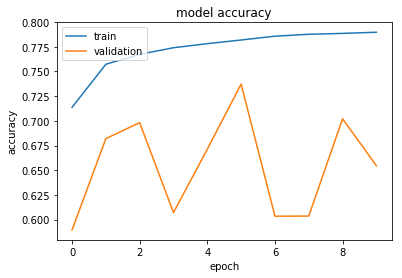

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

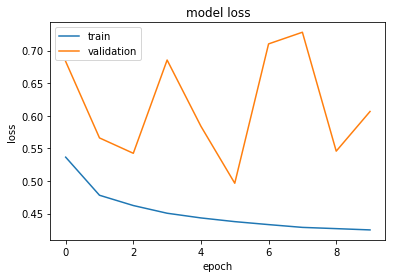

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
y_prob = model.predict([left_test,rigth_test])

In [21]:
y_prob[y_prob >= 0.5] = 1

In [22]:
y_prob[y_prob < 0.5] = 0

In [23]:
accuracy_score(label_test, y_prob)

0.6541921826566871